# Predcition of Hospital Admission Related to Upper Respiratory Tract Infection

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to ipper respiratory tract infection (URTI). We, then, analyse whether prescribing antibiotics is based on the risk of hospital admission or not by building logistic regression (LR) models.

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from sklearn.linear_model import LogisticRegression
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve
from scipy import stats
from datetime import date
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [3]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [4]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'urti_date_'+str(i), 'urti_ab_date_'+str(i), 'urti_ab_type_'+str(i),
                   'incdt_urti_date_'+str(i), 'admitted_urti_date_'+str(i), 'sgss_gp_cov_urti_date_'+str(i)]]
    
    #drop rows with no urti reord
    datum = datum[datum['urti_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with urti_i
    datum = datum[datum['sgss_gp_cov_urti_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'urti_date_'+str(i): 'urti_date', 'urti_ab_date_'+str(i): 'urti_ab_date', 
                           'urti_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_urti_date_'+str(i): 'incdt_urti_date', 'incdt_urti_type_'+str(i): 'incdt_urti_type',
                           'admitted_urti_date_'+str(i): 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_'+str(i): 'sgss_gp_cov_urti_date'},
                inplace=True)
    
    return datum

In [5]:
#summary table of baseline characteristics
def make_summary_table(infection, infection_type, prob_pred):

    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']].columns)
    #dataframe for lr modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_tot = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit']]], axis=1)

    #calculate sums
    summary_table = prob_pred_enc_tot.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_tot.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_tot.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [6]:
#summary table of baseline characteristics
def make_summary_table_deciles(infection, infection_type, prob_pred_enc_lr):
    #calculate sums
    summary_table = prob_pred_enc_lr.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_lr.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_lr.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_deciles_'+infection+'_'+infection_type+'.csv', index=False)

In [7]:
def cox_build(infection, infection_type, data, data_no_abs):
    #randomly splitting data into training (%75) and testing (%25)
    data_dev, data_val = train_test_split(data_no_abs, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_dev,
            duration_col='duration_urti_admitted',
            event_col='event_urti_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics
    #predict cumulative hazard in day 30 in train dataset
    prob_pred = cph.predict_cumulative_hazard(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit']]).loc[[30]].T
    prob_pred.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred['bins'] = pd.qcut(prob_pred['pred'], 10)

    ##add a columns of risk factors, prescribed antibiotics, and hosp event 
    prob_pred = pd.concat([prob_pred, data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit', 'ab_binary', 'event_'+infection+'_admitted']]], axis=1)

    ###needed for figures
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_bin = prob_pred.groupby('bins')[['pred', 'ab_binary', 'event_'+infection+'_admitted']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_prob_mean', 'ab_prob_sum', 'ab_prob_count', 'event_'+infection+'_admitted_mean', 'event_'+infection+'_admitted_sum', 'event_'+infection+'_admitted_count']
    prob_pred_bin['bins'] = prob_pred_bin['bins'].astype(str)
    prob_pred_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_bin_'+infection+'_'+infection_type+'.csv', index=False)

    #plot
    plt.figure(figsize=(10,7))
    sns.lineplot(x='bins', y='ab_prob_mean', data=prob_pred_bin, marker='o', markersize=10)
    g = sns.lineplot(x="bins", data=prob_pred_bin, y="ab_prob_mean", marker='*', linestyle='--', markersize=10)
    plt.ylim(0)
    plt.xlim(0)
    plt.setp(g.collections, alpha=.5) #alpha for markers
    plt.setp(g.lines, alpha=.5) #alpha for line
    plt.xlabel('Decile', fontsize=14)
    plt.ylabel('Mean probability of prescribing antibiotic', fontsize=14)
    plt.gca().set_xticks(np.arange(0,10,1), minor=True)
    plt.grid(b=True, which='major', color='k', linestyle=':', alpha=0.5)
    plt.grid(which='minor', color='k', linestyle=':', alpha=0.5)
    plt.xticks(prob_pred_bin.bins, rotation=90)
    # plt.legend([],[], frameon=False)
    # plt.savefig('../output/aggregate_ab_prob/aggregate_ab_prob_incdt.jpg')
    plt.show()

    return prob_pred, prob_pred_bin

In [8]:
#bootstrap and create lr models
def lr_bootstrap(data):
    sample = data.sample(data.shape[0], replace=True)
    X_tr = sample[[c for c in sample.columns if c != 'ab_binary']]
    y_tr = sample.ab_binary
    lr = LogisticRegression().fit(X_tr, y_tr)
    params = list(lr.coef_[0]) 

    return params

In [9]:
#calculate mean and standard error of lr models with bootstraped data to calculate mean coeffients and intervals of coefficients and odds ratios and their intervals
def get_lr_betas_intervals(data):
    #get column names of inputs
    data_x_columns = data.drop('ab_binary', axis=1).columns
    #create lr models with bootstraped samples for 100 times
    params_samples = pd.DataFrame([lr_bootstrap(data) for _ in range(100)])
    #calculate mean and standard error for coefficients of lrs with samples
    coefs_mean = params_samples.mean()
    coefs_se = params_samples.std()
    z_val = stats.norm.ppf(0.975)
    coefs_se_z_val = coefs_se * z_val
    #create a table of coefficients and their intervals for covariates 
    lr_summary = pd.DataFrame({'covariate': data_x_columns.tolist(), 'coef': coefs_mean, 'coef_lower_95%': coefs_mean - coefs_se_z_val, 'coef_upper_95%': coefs_mean + coefs_se_z_val})
    #clculate odds ratios and their intervals for covariates
    lr_summary[['or', 'or_lower_95%', 'or_upper_95%']] = np.exp(lr_summary[['coef', 'coef_lower_95%', 'coef_upper_95%']])

    return lr_summary

In [10]:
def lr_build_risk_deciles(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)

    #save prob_pred for analysis in r
    prob_pred.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_lr_'+infection+'_'+infection_type+'_r_analysis.csv', index=False)

    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['bins']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['bins']].columns)
    #drop 1st column to take it as reference group
    prob_pred_enc = prob_pred_enc.iloc[: , 1:]
    #dataframe for lr modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr = pd.concat([prob_pred_enc, prob_pred[['ab_binary']]], axis=1)

    #save prob_pred_enc_lr for analysis in r
    prob_pred_enc_lr.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_lr_'+infection+'_'+infection_type+'_r_analysis_binned.csv', index=False)

    ##lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    #building lr model
    lr = LogisticRegression(solver="saga", random_state=42).fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict_proba(data_enc_dev_x)[:,1]
    lr_pred_val = lr.predict_proba(data_enc_val_x)[:,1]

    #calculate aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    #save and print aurocs
    auroc_lr = pd.DataFrame([[auroc_lr_dev, auroc_lr_val]], columns=['auroc_dev', 'auroc_val'])
    auroc_lr.to_csv('../output/hospitalisation_prediction_'+infection+'/auroc_lr_'+infection+'_'+infection_type+'.csv')
    print('\nAUROC of LR for deciles with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))

    #caculate ORs and intervals of LR model, save and print them 
    lr_summary = get_lr_betas_intervals(data_enc_dev)
    lr_summary.to_csv('../output/hospitalisation_prediction_'+infection+'/ors_lr_'+infection+'_'+infection_type+'.csv')
    print('LR summary:\n %s'%(lr_summary))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR model with deciles", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_deciles_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val

In [11]:
def lr_build_risk_riskfactors(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']].columns)
    #drop ref columns
    prob_pred_enc = prob_pred_enc[['age_cat_25_34', 'age_cat_35_44', 'age_cat_45_54', 'age_cat_55_64', 'age_cat_65_74', 'age_cat_75_more', #'age_cat_15_24', 
                                   'sex_male', #'sex_female', 
                                   'CCI_cat_high', 'CCI_cat_low', 'CCI_cat_medium', 'CCI_cat_very_high', #'CCI_cat_very_low', 
                                   'flu_vaccine_yes', #'flu_vaccine_no',
                                   'bmi_cat_obese', 'bmi_cat_overweight', 'bmi_cat_underweight', 'bmi_cat_unknown', #'bmi_cat_healthy_weight',
                                   'region_yorkshire', 'region_east_midlands', 'region_london', 'region_north_east', 'region_north_west', 'region_south_east', 'region_south_west', 'region_west_midlands', #'region_east', 
                                   'imd_very_unaffluent', 'imd_medium', 'imd_affluent', 'imd_very_affluent', 'imd_unknown', #'imd_unaffluent',
                                   'ethnicity_asian', 'ethnicity_other', 'ethnicity_unknown', 'ethnicity_mixed', 'ethnicity_black', #'ethnicity_white', 
                                   'smoking_smoker', 'smoking_never_smoked', 'smoking_unknown', #'smoking_ex_smoker', 
                                   'season_spring', 'season_summer', 'season_winter', #'season_autumn',
                                   ]]
    #dataframe for lr modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit', 'ab_binary']]], axis=1)

    ##lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    #building lr model
    lr = LogisticRegression(solver="saga", random_state=42).fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict_proba(data_enc_dev_x)[:,1]
    lr_pred_val = lr.predict_proba(data_enc_val_x)[:,1]

    #print aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    #save and print aurocs
    auroc_lr = pd.DataFrame([[auroc_lr_dev, auroc_lr_val]], columns=['auroc_dev', 'auroc_val'])
    auroc_lr.to_csv('../output/hospitalisation_prediction_'+infection+'/auroc_lr_'+infection+'_'+infection_type+'.csv')
    print('\nAUROC of LR for risk factors with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))

    #caculate ORs and intervals of LR model, save and print them 
    lr_summary = get_lr_betas_intervals(data_enc_dev)
    lr_summary.to_csv('../output/hospitalisation_prediction_'+infection+'/ors_lr_'+infection+'_'+infection_type+'.csv')
    print('LR summary:\n %s'%(lr_summary))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of lr models with risk factors", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_riskfactors_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val

In [12]:
def calibration_lr(infection, infection_type, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val):
    ##calibration for LR
    lr_prob_pred_dev = pd.DataFrame(data=lr_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_dev['bins'] = pd.qcut(lr_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_dev = pd.merge(lr_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_dev_groupby_bin = lr_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_dev_groupby_bin['ab_binary_proportion'] = lr_prob_pred_dev_groupby_bin['ab_binary_sum']/lr_prob_pred_dev_groupby_bin['ab_binary_count']
    #create dataframe of predictions
    lr_prob_pred_val = pd.DataFrame(data=lr_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_val['bins'] = pd.qcut(lr_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_val = pd.merge(lr_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_val_groupby_bin = lr_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_val_groupby_bin['ab_binary_proportion'] = lr_prob_pred_val_groupby_bin['ab_binary_sum']/lr_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(lr_prob_pred_dev_groupby_bin.pred_mean, lr_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#408678', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(lr_prob_pred_val_groupby_bin.pred_mean, lr_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#6ce0c9', linestyle='dashed', marker='v', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of LR model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#408678', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#6ce0c9', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.6)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_lr_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

## 1- data preparation

In [13]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_urti.csv.gz')

In [14]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [15]:
#process 20 urtis and concatenate them 
data_urti_1 = proc_infec_data(data,1)
data_urti_2 = proc_infec_data(data,2)
data_urti_3 = proc_infec_data(data,3)
data_urti_4 = proc_infec_data(data,4)
data_urti_5 = proc_infec_data(data,5)
data_urti_6 = proc_infec_data(data,6)
data_urti_7 = proc_infec_data(data,7)
data_urti_8 = proc_infec_data(data,8)
data_urti_9 = proc_infec_data(data,9)
data_urti_10 = proc_infec_data(data,10)
data_urti_11 = proc_infec_data(data,11)
data_urti_12 = proc_infec_data(data,12)
data_urti_13 = proc_infec_data(data,13)
data_urti_14 = proc_infec_data(data,14)
data_urti_15 = proc_infec_data(data,15)
data_urti_16 = proc_infec_data(data,16)
data_urti_17 = proc_infec_data(data,17)
data_urti_18 = proc_infec_data(data,18)
data_urti_19 = proc_infec_data(data,19)
data_urti_20 = proc_infec_data(data,20)

data_urti = pd.concat([data_urti_1, data_urti_2, data_urti_3, data_urti_4, data_urti_5, data_urti_6, data_urti_7, data_urti_8, data_urti_9, data_urti_10, data_urti_11, data_urti_12, data_urti_13, data_urti_14, data_urti_15, data_urti_16, data_urti_17, data_urti_18, data_urti_19, data_urti_20])
data_urti.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [16]:
##add variable season
#convert data types
data_urti['urti_date'] = data_urti['urti_date'].astype('datetime64[ns]')
data_urti['admitted_urti_date'] = data_urti['admitted_urti_date'].astype('datetime64[ns]')
data_urti.died_date = data_urti.died_date.astype('datetime64[ns]')
data_urti.deregistered_date = data_urti.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_urti['date'] = data_urti['urti_date'] 
data_urti['date'] = data_urti['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_urti with today's date in year and month
data_urti = data_urti[data_urti['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_urti = data_urti[data_urti['date'] != last_1_month_date_y_m]
data_urti = data_urti[data_urti['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of urti records
data_urti['season'] = np.nan
data_urti['date_month'] = pd.DatetimeIndex(data_urti['date']).month

conditions = [
    (data_urti['date_month'] >= 3) & (data_urti['date_month'] <= 5),
    (data_urti['date_month'] >= 6) & (data_urti['date_month'] <= 8),
    (data_urti['date_month'] >= 9) & (data_urti['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_urti['season'] = np.select(conditions, choices, default='winter')

In [17]:
#add variable time period
data_urti.loc[(data_urti['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_urti.loc[((data_urti['date'] >= '2020-05') & (data_urti['date'] <= '2021-04')), 'period'] = 'during_pandemic'
data_urti.loc[(data_urti['date'] >= '2021-05'), 'period'] = 'post_2nd_lockdown'

#drop any row with nan in period column
data_urti = data_urti[data_urti['period'].notna()]

#### event and duration

In [18]:
#scenario 1
#not hosped (nothing happened)
data_urti.loc[data_urti['admitted_urti_date'].isnull(), 'event_urti_admitted'] = 0

In [19]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_urti['delta_urti_admitted'] = (data_urti['admitted_urti_date'] - data_urti['urti_date']).dt.days
data_urti.loc[((data_urti['delta_urti_admitted'] >= 0) & (data_urti['delta_urti_admitted'] <= 30)), 'event_urti_admitted'] = 1

#scenario 2
#drop whoever was admitted before urti consultation, i.e. negative value for delta_urti_admitted
data_urti = data_urti[~(data_urti['delta_urti_admitted'] < 0)]

In [20]:
#scenario 3
#censor died patients
data_urti['delta_admitted_died'] = (data_urti['died_date'] - data_urti['admitted_urti_date']).dt.days
data_urti.loc[data_urti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_urti.loc[((data_urti['delta_admitted_died'] >= 0) & (data_urti['delta_admitted_died'] <= 30)), 'event_urti_admitted'] = 0

#scenario 3
#censor deregistered patients
data_urti['delta_admitted_deregistered'] = (data_urti['deregistered_date'] - data_urti['admitted_urti_date']).dt.days
data_urti.loc[data_urti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_urti.loc[((data_urti['delta_admitted_deregistered'] > 0) & (data_urti['delta_admitted_deregistered'] <= 30)), 'event_urti_admitted'] = 0

#agg scenario 3s
data_urti['delta_admitted_died_deregistered'] = data_urti['delta_admitted_deregistered'].combine_first(data_urti['delta_admitted_died'])
data_urti.loc[data_urti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [21]:
#scenario 1
#any other patients (nothing happened)
data_urti['event_urti_admitted'] = data_urti['event_urti_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_urti['duration_urti_admitted'] = data_urti['delta_urti_admitted'].combine_first(data_urti['delta_admitted_died_deregistered'])
data_urti['duration_urti_admitted'] = data_urti['duration_urti_admitted'].replace(np.NaN, 30)
data_urti.loc[(data_urti['duration_urti_admitted'] > 30), 'duration_urti_admitted'] = 30

#give value 1 to event_urti_admitted if duration_urti_admitted is greater or equal to 0 and less than 30
data_urti.loc[((data_urti['duration_urti_admitted'] >= 0) & (data_urti['duration_urti_admitted'] < 30)), 'event_urti_admitted'] = 1

#drop any rows with value 0 in duration column
data_urti = data_urti[~(data_urti['duration_urti_admitted'] == 0)]

In [22]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_urti.loc[((data_urti['delta_urti_admitted'] > 0) & (data_urti['delta_urti_admitted'] < 30)), 'event_urti_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [23]:
#drop anybody with age less than 18 or 0!
data_urti = data_urti[~(data_urti['age'] < 18)] 
data_urti['age'][data_urti['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_urti = data_urti[data_urti['age_cat'] != '0-4']
data_urti = data_urti[data_urti['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_urti['bmi'][data_urti['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_urti['bmi'] = data_urti['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_urti['antibacterial_brit'][data_urti['antibacterial_brit'] < 0] = np.nan

In [24]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_urti = data_urti.replace({"sex": dict_sex})
data_urti = data_urti.replace({"smoking": dict_smoking})

In [25]:
#drop rows with missing region
if ('region' in data_urti.columns) and (data_urti['region'].isnull().sum() > 0):
   data_urti = data_urti[data_urti['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_urti.columns) and (data_urti['antibacterial_brit'].isnull().sum() > 0):
    data_urti['antibacterial_brit'] = data_urti['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_urti.columns) and (data_urti['ethnicity'].isnull().sum() > 0):
    data_urti['ethnicity'] = data_urti['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking' in data_urti.columns) and (data_urti['smoking'].isnull().sum() > 0):
    data_urti['smoking'] = data_urti['smoking'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_urti.columns) and (data_urti['imd'].isnull().sum() > 0):
    data_urti['imd'] = data_urti['imd'].fillna(0)

In [26]:
#missing values of bmi assign 5 and 0; categorise bmi
data_urti['bmi_cat'] = 5

for idx, x in enumerate(data_urti['bmi_cat']):
    if data_urti.iat[idx, data_urti.columns.get_loc('bmi')] >= 30:
        data_urti.iat[idx, data_urti.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_urti.iat[idx, data_urti.columns.get_loc('bmi')] >= 25) and (data_urti.iat[idx, data_urti.columns.get_loc('bmi')] < 30):
        data_urti.iat[idx, data_urti.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_urti.iat[idx, data_urti.columns.get_loc('bmi')] >= 18.5) and (data_urti.iat[idx, data_urti.columns.get_loc('bmi')] < 25):
        data_urti.iat[idx, data_urti.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_urti.iat[idx, data_urti.columns.get_loc('bmi')] < 18.5:
        data_urti.iat[idx, data_urti.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_urti.columns) and (data_urti['bmi_cat'].isnull().sum() > 0):
    data_urti['bmi_cat'] = data_urti['bmi_cat'].fillna(0)

In [27]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_urti.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_urti['ab_type_cat'] = np.where(data_urti['ab_type'].isin(ab_series[mask].index),'other',data_urti['ab_type'])
#assign no to non ab users
data_urti.loc[data_urti['urti_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_urti['ab_type_cat'] = data_urti['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [28]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'mixed', 3.0: 'asian', 4.0: 'black', 5.0: 'other', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_urti = data_urti.replace({"sex": dict_sex})
data_urti = data_urti.replace({"ethnicity": dict_ethnicity})
data_urti = data_urti.replace({"smoking": dict_smoking})
data_urti = data_urti.replace({"imd": dict_imd})
data_urti = data_urti.replace({"bmi_cat": dict_bmi})
data_urti = data_urti.replace({"flu_vaccine": dict_flu})
data_urti = data_urti.replace({"region": dict_region})
data_urti = data_urti.replace({"age_cat": dict_age})
data_urti = data_urti.replace({"ab_type_cat": dict_ab_type})

### 2-5- categorising and assigning max value for continuous variables

In [29]:
#categorise CCI
data_urti['CCI_cat'] = pd.cut(data_urti['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_urti['antibacterial_brit'].clip(0, data_urti['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

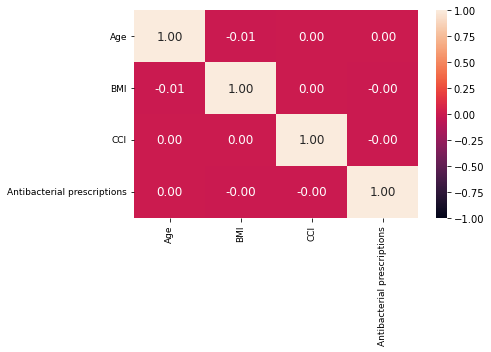

In [30]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_urti[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/corr_urti.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [31]:
data_urti = data_urti[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 
                                   'antibacterial_brit', 'urti_ab_date', 'ab_type_cat', 'incdt_urti_date', 'date', 'period',
                                   'event_urti_admitted', 'duration_urti_admitted'
                                    ]]

In [32]:
#switch variable urti_ab_date into a binary variable
data_urti[['ab_binary']] = data_urti[['urti_ab_date']].where(data_urti[['urti_ab_date']].isnull(), 1).fillna(0).astype(int)
#incident and prevalent infection 
data_urti_incdt = data_urti[data_urti['incdt_urti_date'] == 0]
data_urti_prevl = data_urti[data_urti['incdt_urti_date'] == 1]

#no antibiotics and incident hospital admission
data_urti_no_abs_incdt = data_urti_incdt[data_urti_incdt['ab_binary'] == 0]
#with antibiotics and incident hospital admission
data_urti_abs_incdt = data_urti_incdt[data_urti_incdt['ab_binary'] == 1]

#no antibiotics and prevalent hospital admission
data_urti_no_abs_prevl = data_urti_prevl[data_urti_prevl['ab_binary'] == 0]
#with antibiotics and prevalent hospital admission
data_urti_abs_prevl = data_urti_prevl[data_urti_prevl['ab_binary'] == 1]

In [33]:
##subcohorts for stratification by period
#incident and prevalent infection stratified by time period categories
data_urti_incdt_prepandemic = data_urti_incdt[data_urti_incdt['period'] == 'prepandemic']
data_urti_incdt_during_pandemic = data_urti_incdt[(data_urti_incdt['period'] == 'during_pandemic')]
data_urti_incdt_post_2nd_lockdown = data_urti_incdt[data_urti_incdt['period'] == 'post_2nd_lockdown']
data_urti_prevl_prepandemic = data_urti_prevl[data_urti_prevl['period'] == 'prepandemic']
data_urti_prevl_during_pandemic = data_urti_prevl[(data_urti_prevl['period'] == 'during_pandemic')]
data_urti_prevl_post_2nd_lockdown = data_urti_prevl[data_urti_prevl['period'] == 'post_2nd_lockdown']

#no antibiotics and incident hospital admission
data_urti_no_abs_incdt_prepandemic = data_urti_incdt_prepandemic[data_urti_incdt_prepandemic['ab_binary'] == 0]
data_urti_no_abs_incdt_during_pandemic = data_urti_incdt_during_pandemic[data_urti_incdt_during_pandemic['ab_binary'] == 0]
data_urti_no_abs_incdt_post_2nd_lockdown = data_urti_incdt_post_2nd_lockdown[data_urti_incdt_post_2nd_lockdown['ab_binary'] == 0]
data_urti_no_abs_prevl_prepandemic = data_urti_prevl_prepandemic[data_urti_prevl_prepandemic['ab_binary'] == 0]
data_urti_no_abs_prevl_during_pandemic = data_urti_prevl_during_pandemic[data_urti_prevl_during_pandemic['ab_binary'] == 0]
data_urti_no_abs_prevl_post_2nd_lockdown = data_urti_prevl_post_2nd_lockdown[data_urti_prevl_post_2nd_lockdown['ab_binary'] == 0]

In [34]:
#store data for plotting hosp admission counts and percentages
%store data_urti
# save data
data_urti.to_csv('../output/hospitalisation_prediction_urti/data_urti.csv')

Stored 'data_urti' (DataFrame)


## 5- modelling of antibiotics prediction based on risk of hospital admission
### 5-0- summary tables

In [35]:
#make summary tables
make_summary_table('urti', 'no_abs_incdt', data_urti_no_abs_incdt)
make_summary_table('urti', 'abs_incdt', data_urti_abs_incdt)
make_summary_table('urti', 'no_abs_prevl', data_urti_no_abs_prevl)
make_summary_table('urti', 'abs_prevl', data_urti_abs_prevl)

### 5-1- incident

<lifelines.CoxPHFitter: fitted with 103626 total observations, 102951 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 103626
number of events observed = 675
   partial log-likelihood = -7777.00
         time fit was run = 2023-10-18 13:25:21 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.08       1.08       0.12            -0.15             0.31                 0.86                 1.36
CCI_cat[T.medium]                0.22       1.25       0.13            -0.02             0.47                 0.98                 1.60
CCI_cat[T.high]                 -0.06       0.94       0.16            -0.37             0.25                 0.69                 1.29
CCI_cat[T.very_high]             0.01       1.01       0.14            -0.26             0.28                 0.77                 1.32
age_cat[T.25_34]                 0.04       1.04       0.14            -0.24             0.32                 0.78                 1.38
age_cat[T.35_44]                 0.01       1.01       0.15            -0.28             0.29                 0.76                 1.34
age_cat[T.45_54]                -0.18       0.84       0.15            -0.48             0.12                 0.62                 1.13
age_cat[T.55_64]                 0.22       1.25       0.14            -0.05             0.49                 0.95                 1.64
age_cat[T.65_74]                 0.01       1.01       0.15            -0.27             0.29                 0.76                 1.34
age_cat[T.75_more]               0.00       1.00       0.15            -0.28             0.29                 0.75                 1.33
antibacterial_brit              -0.01       0.99       0.03            -0.06             0.04                 0.94                 1.04
bmi_cat[T.obese]                 0.22       1.25       0.16            -0.09             0.53                 0.91                 1.70
bmi_cat[T.overweight]            0.13       1.14       0.19            -0.24             0.51                 0.79                 1.67
bmi_cat[T.underweight]           0.30       1.36       0.25            -0.19             0.80                 0.82                 2.23
bmi_cat[T.unknown]               0.25       1.29       0.17            -0.08             0.58                 0.93                 1.79
ethnicity[T.other]               0.14       1.15       0.19            -0.24             0.51                 0.79                 1.67
ethnicity[T.unknown]            -0.08       0.92       0.16            -0.40             0.24                 0.67                 1.27
ethnicity[T.white]               0.03       1.03       0.15            -0.26             0.33                 0.77                 1.39
flu_vaccine[T.yes]               0.02       1.02       0.13            -0.23             0.27                 0.79                 1.31
imd[T.medium]                    0.00       1.00       0.12            -0.24             0.25                 0.79                 1.28
imd[T.unaffluent]               -0.02       0.98       0.12            -0.26             0.22                 0.77                 1.25
imd[T.unknown]                   0.10       1.10       0.19            -0.27             0.46                 0.76                 1.58
imd[T.very_affluent]            -0.06       0.94       0.13            -0.31             0.18                 0.73                 1.20
imd[T.very_unaffluent]          -0.04       0.96       0.12            -0.28             0.21                 0.75                 1.23
region[T.east_midlands]         -0.27       0.76       0.18      

13032


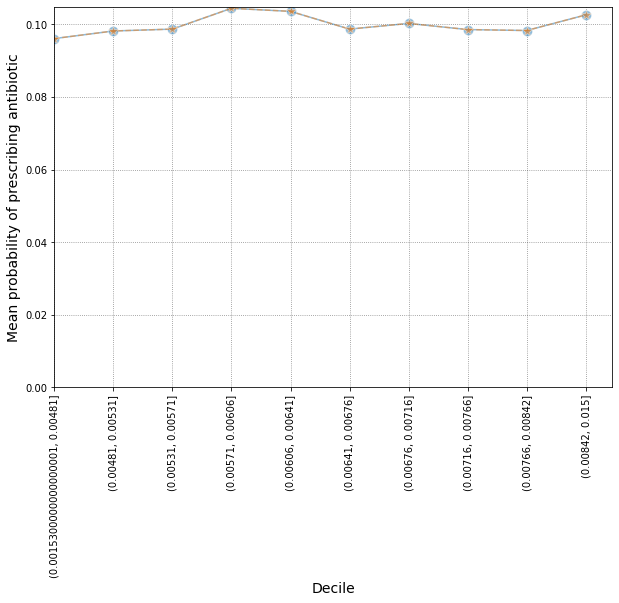


AUROC of LR for deciles with development and validation data: 0.50834 and 0.50257
LR summary:
                  covariate      coef  coef_lower_95%  coef_upper_95%  \
0  bins_(0.00481, 0.00531]  0.043170       -0.036338        0.122679   
1  bins_(0.00531, 0.00571]  0.053566       -0.030099        0.137230   
2  bins_(0.00571, 0.00606]  0.121124        0.044101        0.198146   
3  bins_(0.00606, 0.00641]  0.088826       -0.000130        0.177783   
4  bins_(0.00641, 0.00676]  0.043199       -0.043995        0.130392   
5  bins_(0.00676, 0.00716]  0.037079       -0.045009        0.119167   
6  bins_(0.00716, 0.00766]  0.051687       -0.033906        0.137280   
7  bins_(0.00766, 0.00842]  0.030130       -0.056257        0.116517   
8    bins_(0.00842, 0.015]  0.071562       -0.013508        0.156632   

         or  or_lower_95%  or_upper_95%  
0  1.044116      0.964314      1.130521  
1  1.055026      0.970350      1.147092  
2  1.128765      1.045088      1.219141  
3  1.092891    

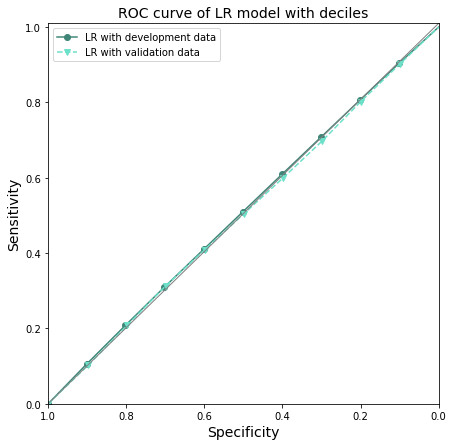

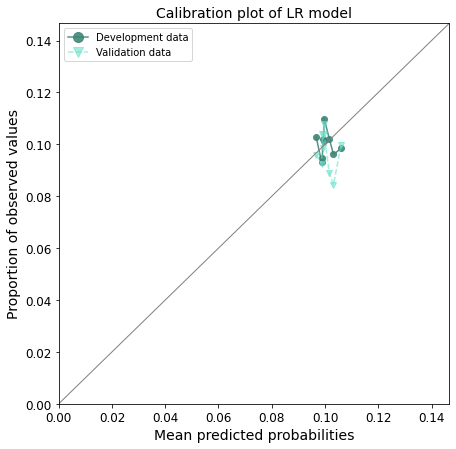


AUROC of LR for risk factors with development and validation data: 0.51569 and 0.50131
LR summary:
                       covariate      coef  coef_lower_95%  coef_upper_95%  \
0                 age_cat_25_34  0.015827       -0.054944        0.086599   
1                 age_cat_35_44  0.047739       -0.016232        0.111710   
2                 age_cat_45_54 -0.064944       -0.134020        0.004132   
3                 age_cat_55_64 -0.010144       -0.080900        0.060612   
4                 age_cat_65_74  0.004096       -0.063613        0.071804   
5               age_cat_75_more -0.007401       -0.074723        0.059920   
6                      sex_male -0.002814       -0.042202        0.036574   
7                  CCI_cat_high  0.020987       -0.055437        0.097411   
8                   CCI_cat_low -0.012618       -0.067389        0.042153   
9                CCI_cat_medium -0.023974       -0.086426        0.038478   
10            CCI_cat_very_high -0.016751       -0.0

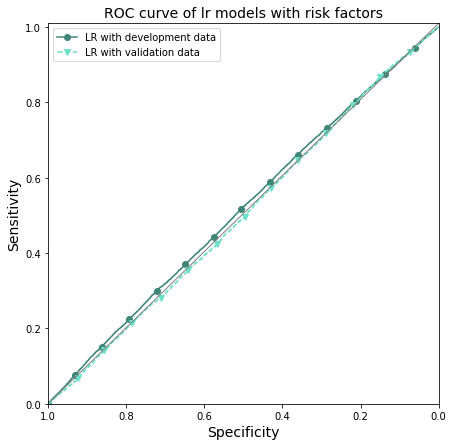

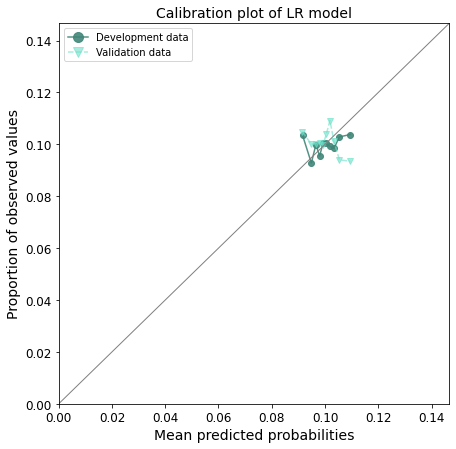

In [36]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_urti_no_abs_incdt, prob_pred_urti_no_abs_incdt_bin = cox_build('urti', 'incdt', data_urti_incdt, data_urti_no_abs_incdt)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build lr models with deciles as predictors
    prob_pred_enc_lr_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt = lr_build_risk_deciles('urti', 'incdt_deciles', prob_pred_urti_no_abs_incdt)
    #calibration plots of lr with deciles
    calibration_lr('urti', 'incdt_deciles', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt)
except:
    print("error_2: lr model for deciles did not converge or failed to finalise or their calibration plot failed.")

try:
    #build lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
    prob_pred_enc_lr_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt = lr_build_risk_riskfactors('urti', 'incdt_riskfactors', prob_pred_urti_no_abs_incdt)
    #calibration plots of lr with risk factors
    calibration_lr('urti', 'incdt_riskfactors', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt)
except:
    print("error_3: lr model for risk factors did not converge or failed to finalise or their calibration plot failed.")

#### 5-2- prevalent

<lifelines.CoxPHFitter: fitted with 11395 total observations, 11322 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 11395
number of events observed = 73
   partial log-likelihood = -663.35
         time fit was run = 2023-10-18 13:28:20 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.26       1.30       0.37            -0.47             0.99                 0.63                 2.68
CCI_cat[T.medium]               -0.14       0.87       0.44            -1.00             0.72                 0.37                 2.05
CCI_cat[T.high]                  0.36       1.43       0.46            -0.54             1.26                 0.58                 3.53
CCI_cat[T.very_high]             0.52       1.68       0.40            -0.27             1.31                 0.76                 3.71
age_cat[T.25_34]                -0.05       0.95       0.43            -0.89             0.79                 0.41                 2.20
age_cat[T.35_44]                 0.12       1.13       0.41            -0.69             0.92                 0.50                 2.52
age_cat[T.45_54]                -0.53       0.59       0.48            -1.48             0.42                 0.23                 1.53
age_cat[T.55_64]                 0.11       1.12       0.40            -0.68             0.90                 0.51                 2.47
age_cat[T.65_74]                -0.30       0.74       0.45            -1.18             0.58                 0.31                 1.79
age_cat[T.75_more]              -0.39       0.67       0.47            -1.31             0.52                 0.27                 1.68
antibacterial_brit               0.05       1.05       0.08            -0.11             0.21                 0.90                 1.24
bmi_cat[T.obese]                 1.16       3.19       0.73            -0.26             2.58                 0.77                13.20
bmi_cat[T.overweight]            1.05       2.87       0.79            -0.50             2.61                 0.61                13.54
bmi_cat[T.underweight]           1.95       7.03       0.84             0.31             3.59                 1.36                36.34
bmi_cat[T.unknown]               1.07       2.91       0.75            -0.39             2.53                 0.67                12.56
ethnicity[T.other]               0.63       1.88       0.56            -0.46             1.73                 0.63                 5.64
ethnicity[T.unknown]             0.08       1.09       0.51            -0.91             1.08                 0.40                 2.94
ethnicity[T.white]               0.06       1.06       0.48            -0.88             0.99                 0.42                 2.68
flu_vaccine[T.yes]              -0.25       0.78       0.43            -1.09             0.58                 0.34                 1.79
imd[T.medium]                    0.23       1.26       0.41            -0.58             1.05                 0.56                 2.85
imd[T.unaffluent]                0.47       1.60       0.40            -0.31             1.26                 0.73                 3.51
imd[T.unknown]                   0.56       1.76       0.55            -0.51             1.64                 0.60                 5.16
imd[T.very_affluent]             0.08       1.09       0.43            -0.76             0.93                 0.47                 2.52
imd[T.very_unaffluent]           0.29       1.34       0.41            -0.51             1.10                 0.60                 2.99
region[T.east_midlands]          0.10       1.11       0.61           

13029


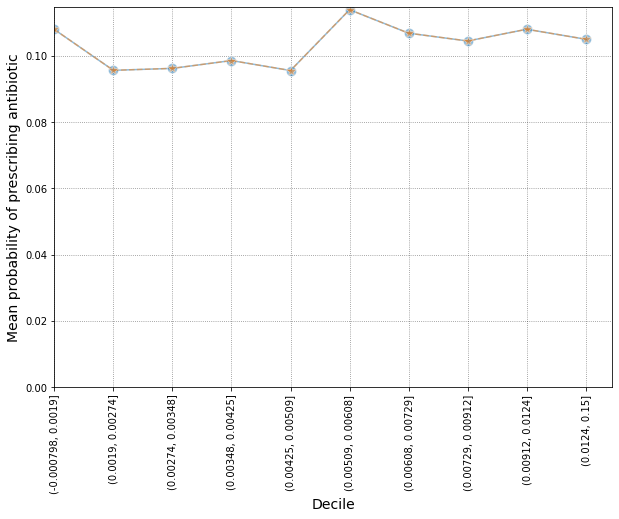


AUROC of LR for deciles with development and validation data: 0.52207 and 0.50128
LR summary:
                  covariate      coef  coef_lower_95%  coef_upper_95%  \
0   bins_(0.0019, 0.00274] -0.095797       -0.329416        0.137823   
1  bins_(0.00274, 0.00348] -0.121124       -0.378931        0.136682   
2  bins_(0.00348, 0.00425] -0.134299       -0.375314        0.106715   
3  bins_(0.00425, 0.00509] -0.156207       -0.373212        0.060798   
4  bins_(0.00509, 0.00608]  0.116762       -0.118887        0.352410   
5  bins_(0.00608, 0.00729]  0.017085       -0.200273        0.234443   
6  bins_(0.00729, 0.00912] -0.008711       -0.254316        0.236895   
7   bins_(0.00912, 0.0124] -0.050895       -0.275957        0.174168   
8      bins_(0.0124, 0.15] -0.056667       -0.286774        0.173439   

         or  or_lower_95%  or_upper_95%  
0  0.908649      0.719344      1.147773  
1  0.885924      0.684593      1.146464  
2  0.874328      0.687074      1.112617  
3  0.855382    

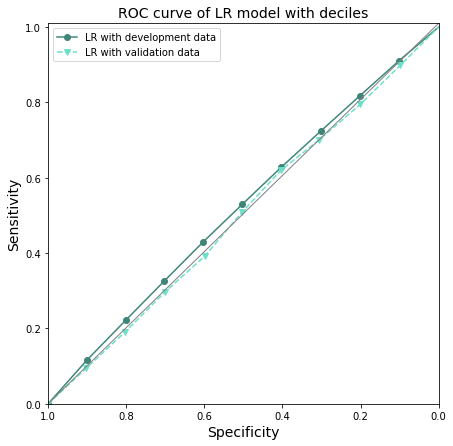

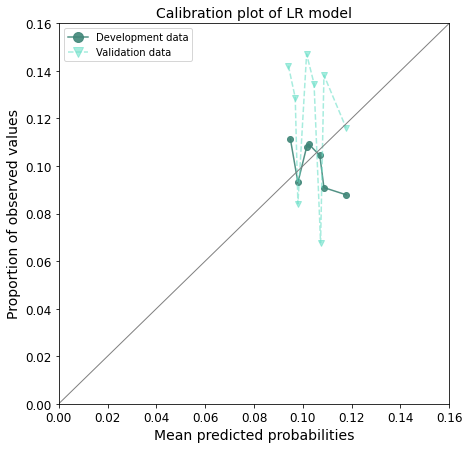


AUROC of LR for risk factors with development and validation data: 0.55577 and 0.47566
LR summary:
                       covariate      coef  coef_lower_95%  coef_upper_95%  \
0                 age_cat_25_34 -0.166162       -0.380978        0.048654   
1                 age_cat_35_44 -0.113453       -0.353190        0.126284   
2                 age_cat_45_54 -0.031986       -0.223640        0.159667   
3                 age_cat_55_64 -0.040721       -0.223491        0.142049   
4                 age_cat_65_74 -0.066239       -0.263396        0.130919   
5               age_cat_75_more -0.085405       -0.298635        0.127825   
6                      sex_male  0.024665       -0.090904        0.140234   
7                  CCI_cat_high -0.162813       -0.400757        0.075131   
8                   CCI_cat_low -0.001568       -0.182941        0.179805   
9                CCI_cat_medium  0.016035       -0.150449        0.182519   
10            CCI_cat_very_high -0.029248       -0.2

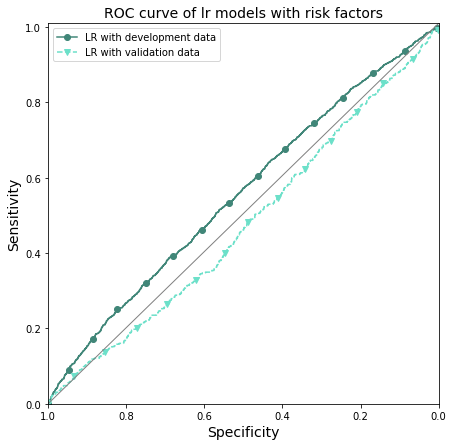

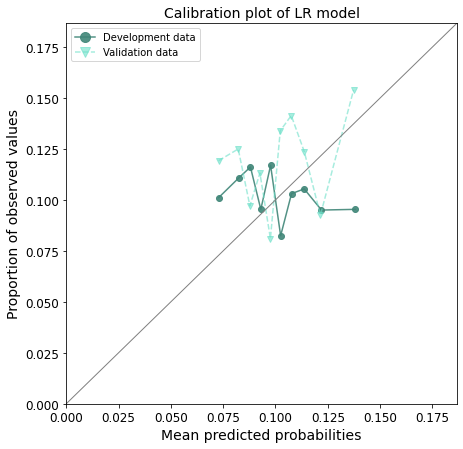

In [37]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_urti_no_abs_prevl, prob_pred_urti_no_abs_prevl_bin = cox_build('urti', 'prevl', data_urti_prevl, data_urti_no_abs_prevl)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build lr models with deciles as predictors
    prob_pred_enc_lr_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl = lr_build_risk_deciles('urti', 'prevl_deciles', prob_pred_urti_no_abs_prevl)
    #calibration plots of lr with deciles
    calibration_lr('urti', 'prevl_deciles', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl)
except:
    print("error_2: lr model for deciles did not converge or failed to finalise or their calibration plot failed.")

try:
    #build lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
    prob_pred_enc_lr_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl = lr_build_risk_riskfactors('urti', 'prevl_riskfactors', prob_pred_urti_no_abs_prevl)
    #calibration plots of lr with risk factors
    calibration_lr('urti', 'prevl_riskfactors', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl)
except:
    print("error_3: lr model for risk factors did not converge or failed to finalise or their calibration plot failed.")

#### 5-3- stratification by time period
#### 5-3-1- incident

<lifelines.CoxPHFitter: fitted with 28511 total observations, 28345 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 28511
number of events observed = 166
   partial log-likelihood = -1681.36
         time fit was run = 2023-10-18 13:28:41 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.05       0.96       0.23            -0.49             0.40                 0.61                 1.50
CCI_cat[T.medium]               -0.09       0.91       0.26            -0.59             0.41                 0.55                 1.50
CCI_cat[T.high]                 -0.31       0.73       0.33            -0.95             0.33                 0.39                 1.39
CCI_cat[T.very_high]            -0.01       0.99       0.26            -0.52             0.51                 0.59                 1.67
age_cat[T.25_34]                -0.02       0.98       0.28            -0.57             0.52                 0.57                 1.68
age_cat[T.35_44]                -0.17       0.85       0.29            -0.73             0.40                 0.48                 1.49
age_cat[T.45_54]                -0.76       0.47       0.34            -1.43            -0.09                 0.24                 0.91
age_cat[T.55_64]                -0.01       0.99       0.28            -0.55             0.54                 0.58                 1.71
age_cat[T.65_74]                -0.16       0.85       0.29            -0.72             0.40                 0.49                 1.49
age_cat[T.75_more]               0.11       1.11       0.27            -0.42             0.64                 0.66                 1.89
antibacterial_brit               0.04       1.04       0.05            -0.07             0.14                 0.94                 1.16
bmi_cat[T.obese]                -0.11       0.90       0.28            -0.66             0.44                 0.52                 1.55
bmi_cat[T.overweight]            0.27       1.31       0.32            -0.36             0.90                 0.70                 2.46
bmi_cat[T.underweight]           0.35       1.42       0.44            -0.51             1.21                 0.60                 3.34
bmi_cat[T.unknown]              -0.43       0.65       0.32            -1.05             0.19                 0.35                 1.20
ethnicity[T.other]               0.72       2.04       0.40            -0.08             1.51                 0.92                 4.52
ethnicity[T.unknown]             0.19       1.20       0.37            -0.54             0.92                 0.58                 2.50
ethnicity[T.white]               0.35       1.42       0.35            -0.33             1.04                 0.72                 2.82
flu_vaccine[T.yes]               0.17       1.19       0.24            -0.31             0.65                 0.74                 1.92
imd[T.medium]                   -0.05       0.96       0.25            -0.54             0.45                 0.58                 1.57
imd[T.unaffluent]                0.23       1.26       0.24            -0.24             0.70                 0.79                 2.01
imd[T.unknown]                   0.32       1.38       0.35            -0.36             1.01                 0.70                 2.74
imd[T.very_affluent]            -0.09       0.91       0.26            -0.60             0.41                 0.55                 1.51
imd[T.very_unaffluent]          -0.27       0.77       0.27            -0.79             0.26                 0.45                 1.29
region[T.east_midlands]         -0.02       0.98       0.34         

13051


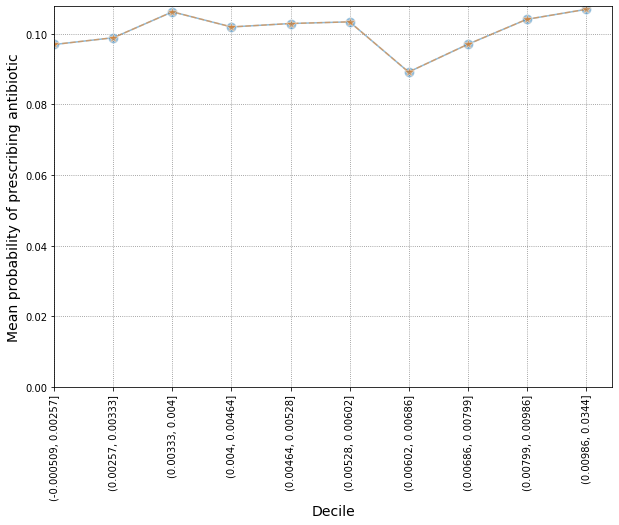


AUROC of LR for deciles with development and validation data: 0.51590 and 0.50950
LR summary:
                  covariate      coef  coef_lower_95%  coef_upper_95%  \
0  bins_(0.00257, 0.00333]  0.012238       -0.150103        0.174578   
1    bins_(0.00333, 0.004]  0.110021       -0.040071        0.260113   
2    bins_(0.004, 0.00464]  0.062759       -0.101239        0.226757   
3  bins_(0.00464, 0.00528]  0.080261       -0.077119        0.237641   
4  bins_(0.00528, 0.00602]  0.099505       -0.054870        0.253880   
5  bins_(0.00602, 0.00686] -0.065973       -0.217926        0.085980   
6  bins_(0.00686, 0.00799]  0.056426       -0.097912        0.210764   
7  bins_(0.00799, 0.00986]  0.092913       -0.055585        0.241412   
8   bins_(0.00986, 0.0344]  0.126888       -0.030555        0.284331   

         or  or_lower_95%  or_upper_95%  
0  1.012313      0.860619      1.190744  
1  1.116302      0.960721      1.297077  
2  1.064770      0.903717      1.254525  
3  1.083570    

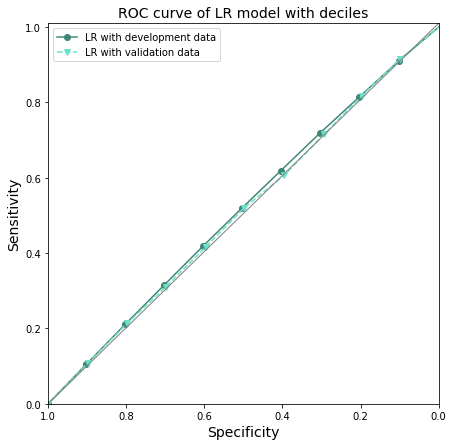

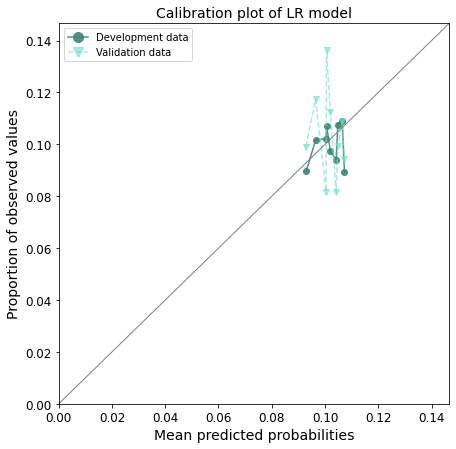

In [38]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_urti_no_abs_incdt_prepandemic, prob_pred_urti_no_abs_incdt_prepandemic_bin = cox_build('urti', 'incdt_prepandemic', data_urti_incdt_prepandemic, data_urti_no_abs_incdt_prepandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build lr models
    prob_pred_enc_lr_incdt_prepandemic, data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic = lr_build_risk_deciles('urti', 'incdt_prepandemic_deciles', prob_pred_urti_no_abs_incdt_prepandemic)
    #calibration plots of lr
    calibration_lr('urti', 'incdt_prepandemic', data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic)
except:
    print("error_2: lr model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 26131 total observations, 25957 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 26131
number of events observed = 174
   partial log-likelihood = -1752.89
         time fit was run = 2023-10-18 13:28:51 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.23       0.79       0.21            -0.64             0.17                 0.53                 1.19
CCI_cat[T.medium]               -0.33       0.72       0.24            -0.80             0.14                 0.45                 1.15
CCI_cat[T.high]                 -0.31       0.73       0.29            -0.89             0.26                 0.41                 1.30
CCI_cat[T.very_high]            -0.51       0.60       0.27            -1.03             0.01                 0.36                 1.01
age_cat[T.25_34]                 0.05       1.05       0.28            -0.50             0.60                 0.60                 1.81
age_cat[T.35_44]                -0.01       0.99       0.28            -0.56             0.55                 0.57                 1.73
age_cat[T.45_54]                 0.03       1.03       0.28            -0.51             0.58                 0.60                 1.78
age_cat[T.55_64]                 0.03       1.03       0.28            -0.52             0.59                 0.59                 1.80
age_cat[T.65_74]                -0.02       0.98       0.29            -0.58             0.54                 0.56                 1.72
age_cat[T.75_more]              -0.14       0.87       0.29            -0.71             0.44                 0.49                 1.55
antibacterial_brit               0.00       1.00       0.05            -0.10             0.11                 0.91                 1.11
bmi_cat[T.obese]                 0.13       1.13       0.30            -0.45             0.71                 0.64                 2.03
bmi_cat[T.overweight]            0.22       1.25       0.35            -0.46             0.90                 0.63                 2.47
bmi_cat[T.underweight]           0.00       1.00       0.53            -1.03             1.03                 0.36                 2.81
bmi_cat[T.unknown]              -0.05       0.96       0.32            -0.67             0.58                 0.51                 1.79
ethnicity[T.other]              -0.26       0.77       0.40            -1.05             0.53                 0.35                 1.70
ethnicity[T.unknown]            -0.18       0.83       0.31            -0.79             0.42                 0.45                 1.53
ethnicity[T.white]              -0.06       0.94       0.28            -0.61             0.50                 0.54                 1.65
flu_vaccine[T.yes]               0.08       1.08       0.25            -0.41             0.57                 0.66                 1.76
imd[T.medium]                   -0.15       0.86       0.26            -0.66             0.37                 0.52                 1.45
imd[T.unaffluent]               -0.13       0.87       0.26            -0.65             0.38                 0.52                 1.47
imd[T.unknown]                   0.06       1.06       0.40            -0.72             0.84                 0.49                 2.31
imd[T.very_affluent]             0.29       1.34       0.24            -0.18             0.75                 0.84                 2.13
imd[T.very_unaffluent]           0.24       1.27       0.24            -0.23             0.71                 0.79                 2.04
region[T.east_midlands]         -0.40       0.67       0.43         

13044


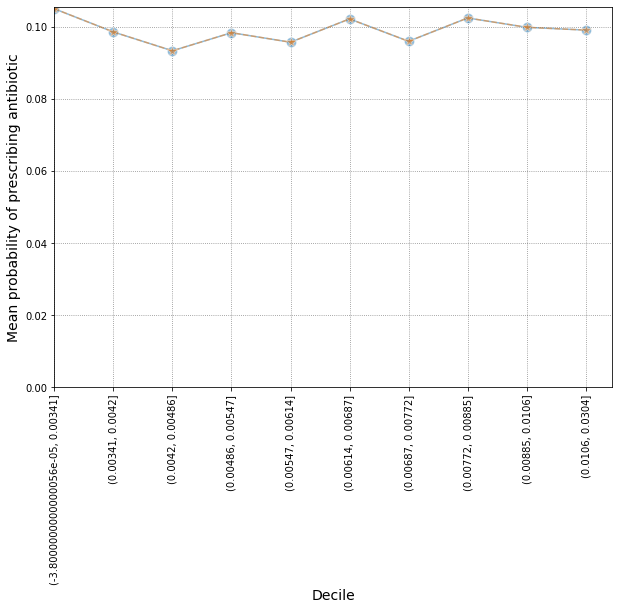


AUROC of LR for deciles with development and validation data: 0.51185 and 0.49934
LR summary:
                  covariate      coef  coef_lower_95%  coef_upper_95%  \
0   bins_(0.00341, 0.0042] -0.070910       -0.239990        0.098169   
1   bins_(0.0042, 0.00486] -0.095902       -0.291755        0.099952   
2  bins_(0.00486, 0.00547] -0.050682       -0.218702        0.117338   
3  bins_(0.00547, 0.00614] -0.096245       -0.256966        0.064477   
4  bins_(0.00614, 0.00687] -0.013542       -0.184112        0.157029   
5  bins_(0.00687, 0.00772] -0.074424       -0.253150        0.104301   
6  bins_(0.00772, 0.00885]  0.016506       -0.143975        0.176987   
7   bins_(0.00885, 0.0106]  0.004018       -0.166735        0.174771   
8    bins_(0.0106, 0.0304] -0.054833       -0.217469        0.107802   

         or  or_lower_95%  or_upper_95%  
0  0.931546      0.786636      1.103149  
1  0.908553      0.746952      1.105118  
2  0.950581      0.803561      1.124499  
3  0.908242    

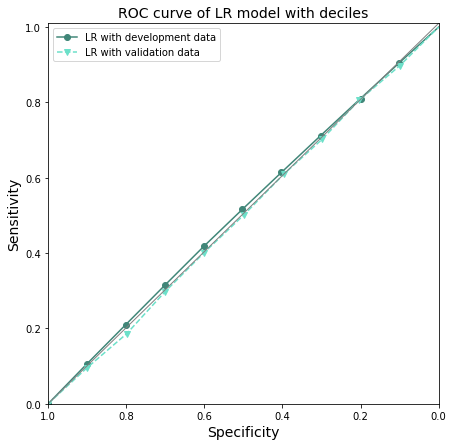

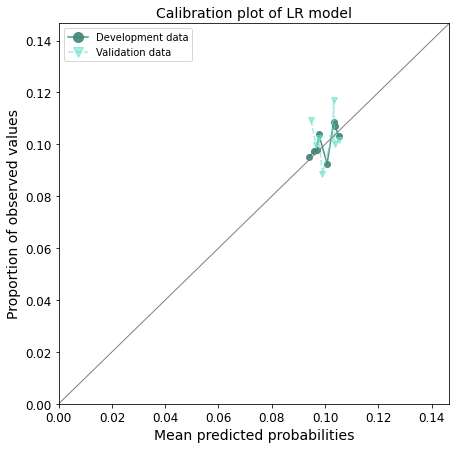

In [39]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_urti_no_abs_incdt_during_pandemic, prob_pred_urti_no_abs_incdt_during_pandemic_bin = cox_build('urti', 'incdt_during_pandemic', data_urti_incdt_during_pandemic, data_urti_no_abs_incdt_during_pandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build lr models
    prob_pred_enc_lr_incdt_during_pandemic, data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic = lr_build_risk_deciles('urti', 'incdt_during_pandemic_deciles', prob_pred_urti_no_abs_incdt_during_pandemic)
    #calibration plots of lr
    calibration_lr('urti', 'incdt_during_pandemic', data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic)
except:
    print("error_2: lr model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 48984 total observations, 48653 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 48984
number of events observed = 331
   partial log-likelihood = -3552.87
         time fit was run = 2023-10-18 13:29:02 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.02       0.98       0.17            -0.35             0.32                 0.70                 1.38
CCI_cat[T.medium]                0.33       1.38       0.18            -0.02             0.67                 0.98                 1.96
CCI_cat[T.high]                  0.15       1.17       0.22            -0.27             0.58                 0.76                 1.78
CCI_cat[T.very_high]             0.05       1.05       0.20            -0.34             0.43                 0.71                 1.54
age_cat[T.25_34]                -0.09       0.91       0.22            -0.52             0.33                 0.60                 1.39
age_cat[T.35_44]                 0.15       1.16       0.20            -0.25             0.55                 0.78                 1.73
age_cat[T.45_54]                -0.15       0.86       0.22            -0.58             0.28                 0.56                 1.32
age_cat[T.55_64]                 0.26       1.30       0.20            -0.13             0.66                 0.88                 1.93
age_cat[T.65_74]                 0.07       1.07       0.21            -0.34             0.47                 0.71                 1.60
age_cat[T.75_more]               0.09       1.09       0.21            -0.32             0.49                 0.73                 1.64
antibacterial_brit              -0.04       0.96       0.04            -0.11             0.04                 0.89                 1.04
bmi_cat[T.obese]                 0.13       1.14       0.22            -0.30             0.57                 0.74                 1.77
bmi_cat[T.overweight]           -0.07       0.93       0.28            -0.62             0.47                 0.54                 1.60
bmi_cat[T.underweight]          -0.01       0.99       0.39            -0.78             0.76                 0.46                 2.14
bmi_cat[T.unknown]               0.30       1.35       0.23            -0.15             0.76                 0.86                 2.13
ethnicity[T.other]               0.18       1.19       0.26            -0.34             0.69                 0.71                 2.00
ethnicity[T.unknown]            -0.30       0.74       0.23            -0.76             0.15                 0.47                 1.16
ethnicity[T.white]              -0.01       0.99       0.21            -0.42             0.40                 0.66                 1.48
flu_vaccine[T.yes]              -0.04       0.96       0.19            -0.41             0.32                 0.67                 1.38
imd[T.medium]                    0.19       1.21       0.17            -0.15             0.53                 0.86                 1.70
imd[T.unaffluent]                0.01       1.01       0.18            -0.35             0.36                 0.70                 1.44
imd[T.unknown]                   0.23       1.26       0.26            -0.27             0.74                 0.76                 2.10
imd[T.very_affluent]             0.05       1.05       0.18            -0.31             0.40                 0.73                 1.49
imd[T.very_unaffluent]          -0.07       0.93       0.19            -0.44             0.29                 0.65                 1.34
region[T.east_midlands]         -0.19       0.83       0.26         

13040


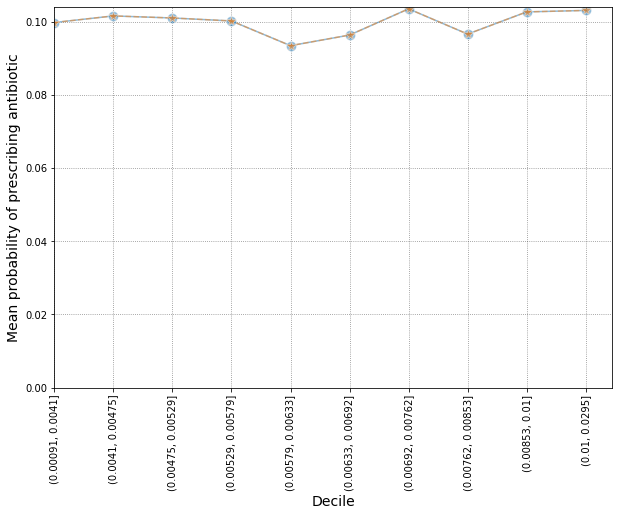


AUROC of LR for deciles with development and validation data: 0.51219 and 0.49879
LR summary:
                  covariate      coef  coef_lower_95%  coef_upper_95%  \
0   bins_(0.0041, 0.00475]  0.056007       -0.082897        0.194911   
1  bins_(0.00475, 0.00529]  0.034869       -0.088730        0.158468   
2  bins_(0.00529, 0.00579]  0.043987       -0.078966        0.166941   
3  bins_(0.00579, 0.00633] -0.025461       -0.149991        0.099068   
4  bins_(0.00633, 0.00692] -0.011710       -0.144245        0.120824   
5  bins_(0.00692, 0.00762]  0.105966       -0.015143        0.227076   
6  bins_(0.00762, 0.00853] -0.000275       -0.126268        0.125717   
7     bins_(0.00853, 0.01]  0.088405       -0.031442        0.208251   
8      bins_(0.01, 0.0295]  0.031120       -0.094965        0.157205   

         or  or_lower_95%  or_upper_95%  
0  1.057605      0.920446      1.215203  
1  1.035484      0.915093      1.171714  
2  1.044969      0.924071      1.181685  
3  0.974860    

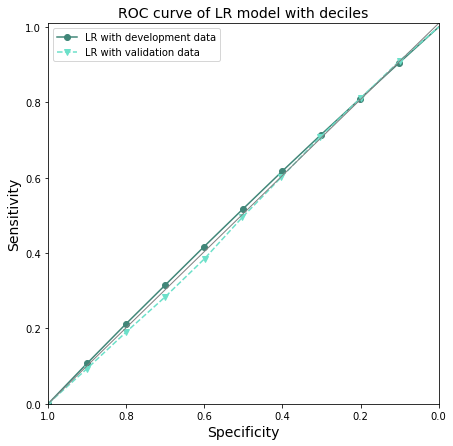

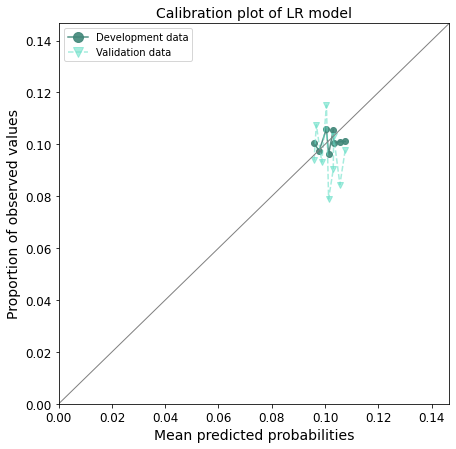

In [40]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_urti_no_abs_incdt_post_2nd_lockdown, prob_pred_urti_no_abs_incdt_post_2nd_lockdown_bin = cox_build('urti', 'incdt_post_2nd_lockdown', data_urti_incdt_post_2nd_lockdown, data_urti_no_abs_incdt_post_2nd_lockdown)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build lr models
    prob_pred_enc_lr_incdt_post_2nd_lockdown, data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown = lr_build_risk_deciles('urti', 'incdt_post_2nd_lockdown_deciles', prob_pred_urti_no_abs_incdt_post_2nd_lockdown)
    #calibration plots of lr
    calibration_lr('urti', 'incdt_post_2nd_lockdown', data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown)
except:
    print("error_2: lr model for deciles did not converge or failed to finalise or their calibration plot failed.")

#### 5-3-2- prevalent

<lifelines.CoxPHFitter: fitted with 3101 total observations, 3086 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 3101
number of events observed = 15
   partial log-likelihood = -92.27
         time fit was run = 2023-10-18 13:29:21 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.56       1.75       0.85            -1.10             2.22                 0.33                 9.17
CCI_cat[T.medium]               -0.57       0.57       1.06            -2.64             1.50                 0.07                 4.50
CCI_cat[T.high]                 -0.38       0.68       1.29            -2.91             2.15                 0.05                 8.57
CCI_cat[T.very_high]             0.61       1.84       0.95            -1.26             2.48                 0.28                11.96
age_cat[T.25_34]                 1.52       4.56       1.20            -0.83             3.87                 0.44                47.72
age_cat[T.35_44]                 1.57       4.81       1.14            -0.67             3.81                 0.51                45.19
age_cat[T.45_54]                 1.55       4.73       1.18            -0.77             3.88                 0.46                48.29
age_cat[T.55_64]                 0.05       1.05       1.44            -2.78             2.87                 0.06                17.70
age_cat[T.65_74]                 0.97       2.64       1.18            -1.34             3.28                 0.26                26.51
age_cat[T.75_more]             -17.32       0.00    5509.13        -10815.01         10780.37                 0.00                  inf
antibacterial_brit               0.18       1.20       0.18            -0.18             0.54                 0.84                 1.72
bmi_cat[T.obese]                20.25   6.26e+08   22983.42        -45026.42         45066.93                 0.00                  inf
bmi_cat[T.overweight]           19.74   3.76e+08   22983.42        -45026.93         45066.42                 0.00                  inf
bmi_cat[T.underweight]          22.48   5.79e+09   22983.42        -45024.19         45069.15                 0.00                  inf
bmi_cat[T.unknown]              20.48   7.84e+08   22983.42        -45026.19         45067.15                 0.00                  inf
ethnicity[T.other]              18.64   1.25e+08    6988.88        -13679.31         13716.59                 0.00                  inf
ethnicity[T.unknown]            18.08   7.11e+07    6988.88        -13679.87         13716.03                 0.00                  inf
ethnicity[T.white]              18.06   6.96e+07    6988.88        -13679.89         13716.01                 0.00                  inf
flu_vaccine[T.yes]              -0.69       0.50       1.08            -2.81             1.43                 0.06                 4.19
imd[T.medium]                    1.61       5.03       1.12            -0.58             3.81                 0.56                45.32
imd[T.unaffluent]                1.24       3.46       1.13            -0.98             3.46                 0.38                31.82
imd[T.unknown]                 -18.10       0.00   10978.26        -21535.10         21498.90                 0.00                  inf
imd[T.very_affluent]             0.67       1.96       1.25            -1.77             3.12                 0.17                22.65
imd[T.very_unaffluent]           0.63       1.88       1.19            -1.70             2.97                 0.18                19.52
region[T.east_midlands]         18.82   1.49e+08    8821.92        -17271.

13357


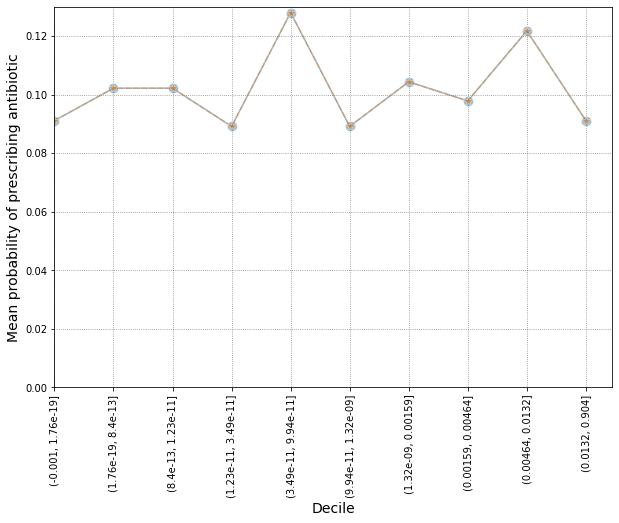


AUROC of LR for deciles with development and validation data: 0.54420 and 0.50670
LR summary:
                    covariate      coef  coef_lower_95%  coef_upper_95%  \
0    bins_(0.00159, 0.00464] -0.068480       -0.547719        0.410758   
1     bins_(0.00464, 0.0132]  0.206135       -0.181696        0.593966   
2       bins_(0.0132, 0.904] -0.177842       -0.656471        0.300787   
3  bins_(1.23e-11, 3.49e-11] -0.219931       -0.668497        0.228636   
4   bins_(1.32e-09, 0.00159]  0.037565       -0.445750        0.520879   
5   bins_(1.76e-19, 8.4e-13]  0.030094       -0.380043        0.440231   
6  bins_(3.49e-11, 9.94e-11]  0.238867       -0.199291        0.677025   
7   bins_(8.4e-13, 1.23e-11] -0.019707       -0.391206        0.351792   
8  bins_(9.94e-11, 1.32e-09] -0.233958       -0.690189        0.222272   

         or  or_lower_95%  or_upper_95%  
0  0.933812      0.578267      1.507961  
1  1.228919      0.833855      1.811158  
2  0.837074      0.518678      1.3509

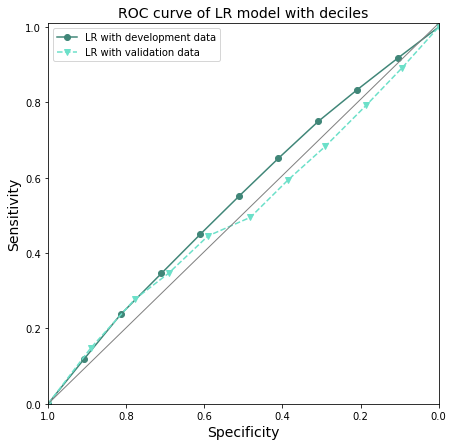

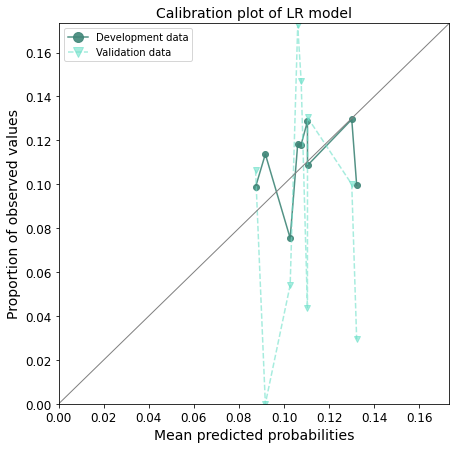

In [41]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_urti_no_abs_prevl_prepandemic, prob_pred_urti_no_abs_prevl_prepandemic_bin = cox_build('urti', 'prevl_prepandemic', data_urti_prevl_prepandemic, data_urti_no_abs_prevl_prepandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build lr models
    prob_pred_enc_lr_prevl_prepandemic, data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic = lr_build_risk_deciles('urti', 'prevl_prepandemic_deciles', prob_pred_urti_no_abs_prevl_prepandemic)
    #calibration plots of lr
    calibration_lr('urti', 'prevl_prepandemic', data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic)
except:
    print("error_2: lr model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 2906 total observations, 2894 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 2906
number of events observed = 12
   partial log-likelihood = -81.35
         time fit was run = 2023-10-18 13:29:25 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.51       0.60       0.93            -2.33             1.31                 0.10                 3.69
CCI_cat[T.medium]               -0.34       0.71       1.02            -2.33             1.66                 0.10                 5.25
CCI_cat[T.high]                  0.56       1.75       1.02            -1.44             2.56                 0.24                12.95
CCI_cat[T.very_high]             0.37       1.44       0.93            -1.45             2.19                 0.23                 8.90
age_cat[T.25_34]               -18.28       0.00    6084.23        -11943.16         11906.60                 0.00                  inf
age_cat[T.35_44]                 0.36       1.43       0.94            -1.48             2.19                 0.23                 8.94
age_cat[T.45_54]                -0.89       0.41       1.25            -3.33             1.55                 0.04                 4.71
age_cat[T.55_64]                -0.02       0.98       1.03            -2.05             2.00                 0.13                 7.41
age_cat[T.65_74]                -0.81       0.45       1.24            -3.24             1.62                 0.04                 5.07
age_cat[T.75_more]               0.29       1.34       0.93            -1.53             2.11                 0.22                 8.27
antibacterial_brit              -0.00       1.00       0.21            -0.42             0.42                 0.66                 1.52
bmi_cat[T.obese]                -0.14       0.87       1.13            -2.35             2.07                 0.10                 7.90
bmi_cat[T.overweight]            0.89       2.44       1.20            -1.45             3.24                 0.23                25.56
bmi_cat[T.underweight]           1.11       3.02       1.48            -1.79             4.00                 0.17                54.87
bmi_cat[T.unknown]              -0.55       0.58       1.25            -3.01             1.91                 0.05                 6.76
ethnicity[T.other]              18.11   7.33e+07    7776.51        -15223.58         15259.80                 0.00                  inf
ethnicity[T.unknown]            18.30   8.83e+07    7776.51        -15223.39         15259.99                 0.00                  inf
ethnicity[T.white]              17.81   5.44e+07    7776.51        -15223.88         15259.50                 0.00                  inf
flu_vaccine[T.yes]              -0.35       0.71       1.07            -2.44             1.74                 0.09                 5.71
imd[T.medium]                   -0.37       0.69       0.78            -1.90             1.16                 0.15                 3.20
imd[T.unaffluent]               -0.99       0.37       0.90            -2.75             0.76                 0.06                 2.14
imd[T.unknown]                 -18.58       0.00    9995.80        -19609.99         19572.83                 0.00                  inf
imd[T.very_affluent]            -0.64       0.53       0.89            -2.38             1.10                 0.09                 3.01
imd[T.very_unaffluent]          -1.63       0.20       1.14            -3.85             0.60                 0.02                 1.82
region[T.east_midlands]        -18.55       0.00    7171.65        -14074.

13162


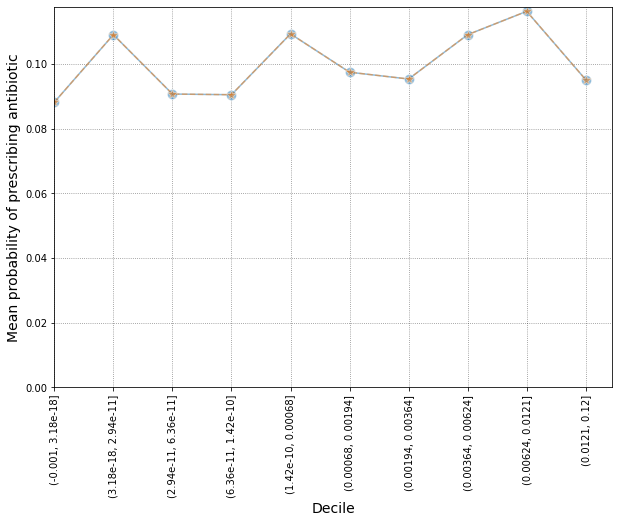


AUROC of LR for deciles with development and validation data: 0.53820 and 0.48642
LR summary:
                    covariate      coef  coef_lower_95%  coef_upper_95%  \
0    bins_(0.00068, 0.00194]  0.036772       -0.457167        0.530711   
1    bins_(0.00194, 0.00364]  0.023379       -0.431038        0.477796   
2    bins_(0.00364, 0.00624]  0.246094       -0.169392        0.661581   
3     bins_(0.00624, 0.0121]  0.394015       -0.050897        0.838926   
4        bins_(0.0121, 0.12]  0.216533       -0.231512        0.664578   
5   bins_(1.42e-10, 0.00068]  0.157462       -0.251297        0.566222   
6  bins_(2.94e-11, 6.36e-11] -0.030877       -0.486761        0.425006   
7  bins_(3.18e-18, 2.94e-11]  0.290603       -0.124134        0.705341   
8  bins_(6.36e-11, 1.42e-10]  0.181647       -0.280872        0.644166   

         or  or_lower_95%  or_upper_95%  
0  1.037456      0.633074      1.700141  
1  1.023655      0.649834      1.612517  
2  1.279020      0.844178      1.9378

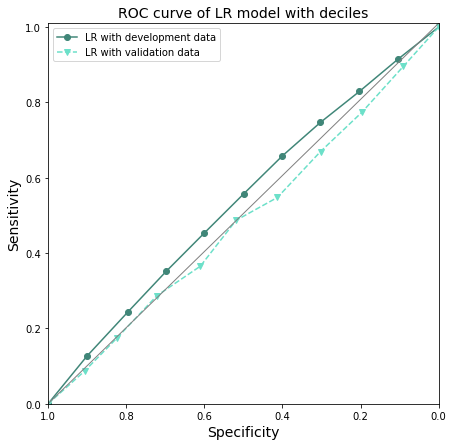

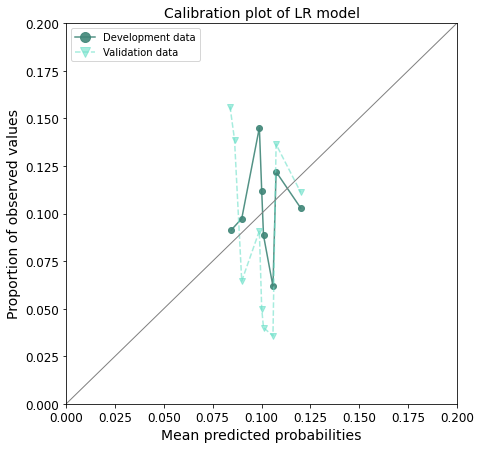

In [42]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_urti_no_abs_prevl_during_pandemic, prob_pred_urti_no_abs_prevl_during_pandemic_bin = cox_build('urti', 'prevl_during_pandemic', data_urti_prevl_during_pandemic, data_urti_no_abs_prevl_during_pandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build lr models
    prob_pred_enc_lr_prevl_during_pandemic, data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic = lr_build_risk_deciles('urti', 'prevl_during_pandemic_deciles', prob_pred_urti_no_abs_prevl_during_pandemic)
    #calibration plots of lr
    calibration_lr('urti', 'prevl_during_pandemic', data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic)
except:
    print("error_2: lr model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 5388 total observations, 5349 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 5388
number of events observed = 39
   partial log-likelihood = -317.31
         time fit was run = 2023-10-18 13:29:29 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   1.33       3.79       0.75            -0.15             2.81                 0.86                16.60
CCI_cat[T.medium]                1.37       3.94       0.78            -0.15             2.89                 0.86                18.03
CCI_cat[T.high]                  1.43       4.17       0.84            -0.21             3.07                 0.81                21.58
CCI_cat[T.very_high]             1.29       3.63       0.80            -0.29             2.87                 0.75                17.57
age_cat[T.25_34]                -0.36       0.69       0.57            -1.49             0.76                 0.23                 2.14
age_cat[T.35_44]                -0.27       0.76       0.54            -1.33             0.79                 0.26                 2.20
age_cat[T.45_54]                -0.72       0.49       0.61            -1.92             0.48                 0.15                 1.62
age_cat[T.55_64]                -0.15       0.86       0.52            -1.16             0.87                 0.31                 2.39
age_cat[T.65_74]                -0.64       0.53       0.61            -1.84             0.57                 0.16                 1.76
age_cat[T.75_more]              -0.46       0.63       0.57            -1.59             0.66                 0.20                 1.93
antibacterial_brit               0.03       1.03       0.11            -0.19             0.25                 0.83                 1.28
bmi_cat[T.obese]                 1.36       3.88       1.02            -0.65             3.36                 0.52                28.84
bmi_cat[T.overweight]            0.82       2.27       1.16            -1.45             3.09                 0.23                21.97
bmi_cat[T.underweight]         -14.51       0.00    2512.27         -4938.46          4909.43                 0.00                  inf
bmi_cat[T.unknown]               1.25       3.49       1.05            -0.80             3.30                 0.45                27.20
ethnicity[T.other]               1.06       2.89       0.84            -0.59             2.71                 0.56                15.03
ethnicity[T.unknown]             0.09       1.10       0.81            -1.49             1.67                 0.23                 5.31
ethnicity[T.white]               0.58       1.79       0.74            -0.87             2.03                 0.42                 7.59
flu_vaccine[T.yes]              -1.55       0.21       1.01            -3.54             0.43                 0.03                 1.54
imd[T.medium]                    0.79       2.21       0.69            -0.56             2.15                 0.57                 8.55
imd[T.unaffluent]                1.00       2.73       0.68            -0.33             2.34                 0.72                10.33
imd[T.unknown]                   1.70       5.49       0.77             0.20             3.21                 1.22                24.76
imd[T.very_affluent]             0.60       1.82       0.71            -0.79             1.99                 0.45                 7.30
imd[T.very_unaffluent]           1.25       3.49       0.65            -0.03             2.53                 0.97                12.54
region[T.east_midlands]          0.16       1.17       0.71            -1

13050


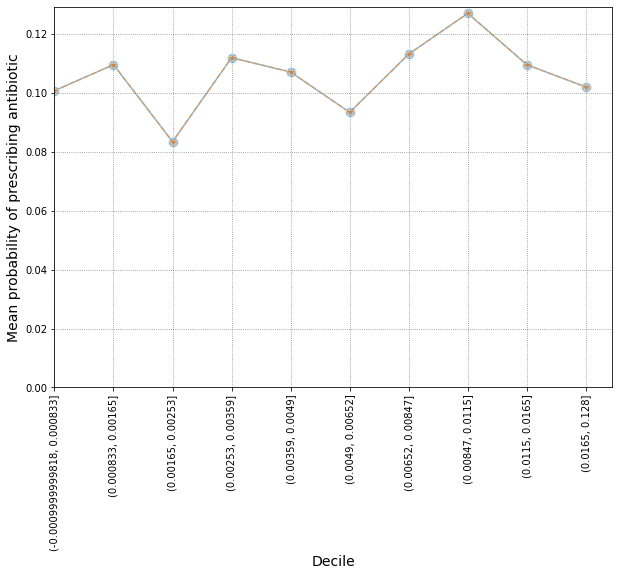


AUROC of LR for deciles with development and validation data: 0.52884 and 0.53025
LR summary:
                   covariate      coef  coef_lower_95%  coef_upper_95%  \
0  bins_(0.000833, 0.00165] -0.066649       -0.400627        0.267329   
1   bins_(0.00165, 0.00253] -0.119654       -0.453294        0.213985   
2   bins_(0.00253, 0.00359]  0.035704       -0.268939        0.340346   
3    bins_(0.00359, 0.0049]  0.083805       -0.219816        0.387425   
4    bins_(0.0049, 0.00652] -0.086352       -0.367295        0.194590   
5   bins_(0.00652, 0.00847]  0.138827       -0.171573        0.449227   
6    bins_(0.00847, 0.0115]  0.208505       -0.105569        0.522578   
7     bins_(0.0115, 0.0165]  0.066520       -0.294135        0.427174   
8      bins_(0.0165, 0.128] -0.018388       -0.349232        0.312456   

         or  or_lower_95%  or_upper_95%  
0  0.935524      0.669900      1.306471  
1  0.887227      0.635531      1.238604  
2  1.036349      0.764190      1.405434  
3  1.

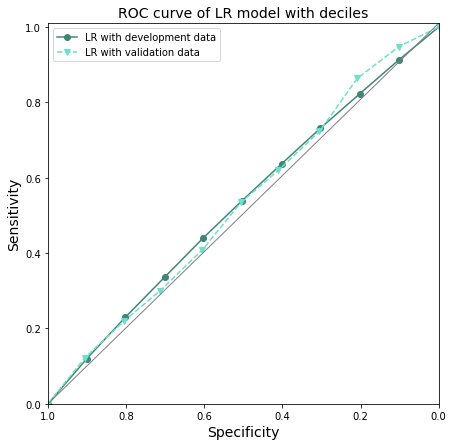

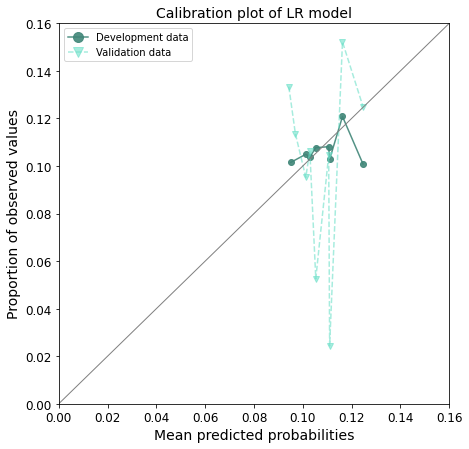

In [43]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_urti_no_abs_prevl_post_2nd_lockdown, prob_pred_urti_no_abs_prevl_post_2nd_lockdown_bin = cox_build('urti', 'prevl_post_2nd_lockdown', data_urti_prevl_post_2nd_lockdown, data_urti_no_abs_prevl_post_2nd_lockdown)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build lr models
    prob_pred_enc_lr_prevl_post_2nd_lockdown, data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown = lr_build_risk_deciles('urti', 'prevl_post_2nd_lockdown_deciles', prob_pred_urti_no_abs_prevl_post_2nd_lockdown)
    #calibration plots of lr
    calibration_lr('urti', 'prevl_post_2nd_lockdown', data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown)
except:
    print("error_2: lr model for deciles did not converge or failed to finalise or their calibration plot failed.")